# 펀다 상점매출예측 모델링 경진대회

### 🧩특징  
안녕하세요 여러분!🙌 상점 신용카드 매출 예측 경진대회에 오신 것을 환영합니다.  
핀테크 기업인 ‘FUNDA(펀다)’는 상환 기간의 매출을 예측하여 신용 점수가 낮거나 담보를 가지지 못하는 우수 상점들에 금융 기회를 제공하려 합니다.  
이번 대회에서는 2년 전 부터 2019년 2월 28일까지의 카드 거래 데이터를 이용해 2019-03-01부터 2019-05-31까지의 각 상점별 3개월 총 매출을 예측하는 것입니다.  


</br>

### 🚣‍♂️목적 
우수 상점 금융 기회 제공을 위한 상점별 총 매출 예측  

</br>

### 📔코드북
funda_train.csv  
* `store_id`: 상점의 고유 아이디  
* `card_id`: 사용한 카드의 고유 아이디  
* `card_company`: 비식별화된 카드 회사  
* `trasacted_date`: 거래 날짜  
* `transacted_time`: 거래 시간(시:분)  
* `installment_term`: 할부 개월 수(포인트 사용 시 (60개월 + 실제할부개월)을 할부개월수에 기재한다.)  
* `region`: 상점의 지역  
* `type_of_business`: 상점의 업종  
* `amount`: 거래액(단위는 원이 아닙니다)  

submission.csv  
* `store_id`: 상점의 고유 아이디
* `amount`: 사용자들은 상점별로 2019-03-01부터 2019-05-31까지의 총 매출을 예측하여 기입

[출처] <a href="https://dacon.io/competitions/official/140472/overview/description">상점 신용카드 매출 예측 경진대회</a>

## Step 1. 필요한 패키지와 데이터셋 불러오기

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pmdarima as pm
import pmdarima
import statsmodels
import rpy2
import rpy2.robjects as robjects  ##R 함수를 쓰기위함
from tqdm import tqdm
from rpy2.robjects import pandas2ri ##pandas를 R 데이터로 형식으로 변환하기 위함
from rpy2.robjects.packages import importr #R 패키지를 import
from pmdarima.arima.stationarity import ADFTest #단위근검정 ADF_TEST
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #AR값을 정하기위한 acf,pcaf
import warnings

In [16]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("data/funda_train.csv")
df.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


## Step 2. 데이터셋 분석

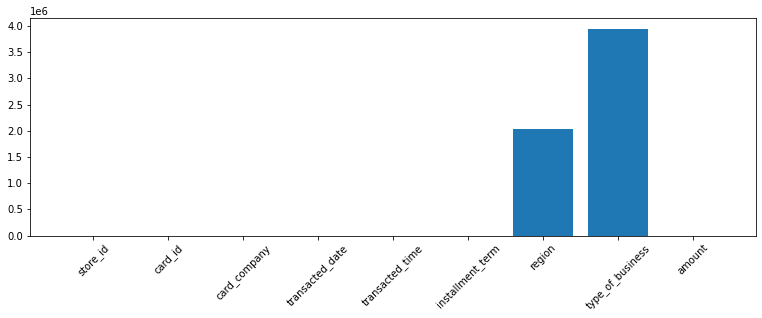

In [18]:
plt.figure(figsize=(13, 4))
plt.bar(df.columns, df.isnull().sum())
plt.xticks(rotation=45) # rotation: 레이블 텍스트 회전
plt.show()

In [19]:
df = df.drop(['region','type_of_business'],axis=1)
df.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount
0,0,0,b,2016-06-01,13:13,0,1857.142857
1,0,1,h,2016-06-01,18:12,0,857.142857
2,0,2,c,2016-06-01,18:52,0,2000.000000
3,0,3,a,2016-06-01,20:22,0,7857.142857
4,0,4,c,2016-06-02,11:06,0,2000.000000


In [21]:
# amount는 거래액
df[df['amount'] < 0]

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount
41,0,40,a,2016-06-10,17:26,2,-8571.428571
347,0,285,a,2016-08-04,17:52,0,-1857.142857
731,0,473,g,2016-10-17,10:32,0,-2000.000000
831,0,230,b,2016-11-03,15:36,0,-85.714286
944,0,138,a,2016-11-28,13:21,0,-57.142857
...,...,...,...,...,...,...,...
6556242,2136,4663626,b,2019-02-01,21:19,0,-13428.571429
6556448,2136,4663760,d,2019-02-15,00:46,0,-6928.571429
6556485,2136,4663779,b,2019-02-18,02:45,0,-5571.428571
6556489,2136,4663780,d,2019-02-18,21:43,0,-8571.428571


## Step 3. 데이터 전처리

* 매출액에 음수 값이 보이고, 환불 금액으로 예상됨
* 환불을 log정규화했을 때 무한대가 나오기 때문에 제거 하기로 결정
* 환불 발생 이전 데이터 중 카드아이디가 같고 환불액의 절대값이 같은 후보 리스트를 찾음
* 환불 후보리스트 중 가장 최근시간(max)을 제거
* 시계열 모델링을 위해 month 단위로 resampling 진행
* 상점 매출이 발생하지 않은 월은 log 정규화시 0이 아닌 최솟값으로 대치하기 위해 2로 대치(log1=0, log2=0.693)
* resampling시 영업 시작 전 데이터는 제거하고 시작일부터 데이터를 유지시킴

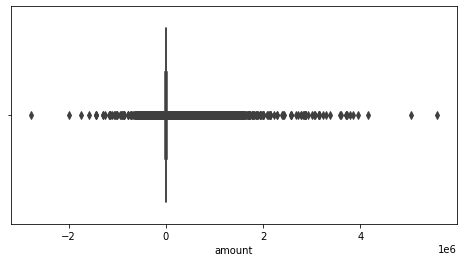

In [23]:
plt.figure(figsize=(8, 4))
sns.boxplot(df["amount"])
plt.show()

In [25]:
df['datetime'] = pd.to_datetime(df.transacted_date+" "+\
                 df.transacted_time, format='%Y-%m-%d %H:%M:%S')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 8 columns):
 #   Column            Dtype         
---  ------            -----         
 0   store_id          int64         
 1   card_id           int64         
 2   card_company      object        
 3   transacted_date   object        
 4   transacted_time   object        
 5   installment_term  int64         
 6   amount            float64       
 7   datetime          datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 400.2+ MB


In [29]:
refund = df[df['amount'] < 0]
non_refund =df[df['amount'] > 0]


In [ ]:
for i in tqdm(df.store_id.unique()):
    

In [ ]:
non_refund